## 10.1 注意力提示

### 10.1 注意力的可视化

In [8]:
import torch
from torch import nn
from IPython import display

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [9]:
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
def use_svg_display():
    # 设置Matplotlib使用SVG格式显示
    backend_inline.set_matplotlib_formats('svg')

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

In [10]:
def show_heatmaps(matrices,xlabel,ylabel,titles=None,figsize=(2.5,2.5),cmap='Reds'):
    use_svg_display()
    num_rows,num_cols=matrices.shape[0],matrices.shape[1]
    fig,axes = plt.subplots(num_rows, num_cols, figsize=figsize,
    sharex=True, sharey=True, squeeze=False)     #sharex=True, sharey=True：所有子图共享x轴和y轴刻度 squeeze=False：即使只有一行或一列也保持二维数组结构
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows- 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);    


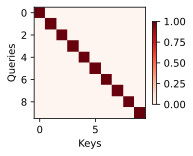

In [11]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))   #eye()是单位阵
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

## 10.2 注意力汇聚：Nadaraya-Watson核回归

### 10.2.1 生成数据集

In [12]:
n_train = 50
x_train , _ = torch.sort(torch.rand(n_train)*5)  #随机生成后排序后的训练样本

In [13]:
def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,)) # 训练样本的输出
x_test = torch.arange(0, 5, 0.1) # 测试样本
y_truth = f(x_test) # 测试样本的真实输出
n_test = len(x_test) # 测试样本数
n_test

50

In [14]:
def plot_kernel_reg(y_hat):
    # 创建画布
    plt.figure(figsize=(5, 3))
    
    # 1. 绘制真实曲线 (Truth)
    plt.plot(x_test, y_truth, label='Truth')
    
    # 2. 绘制预测曲线 (Pred)
    plt.plot(x_test, y_hat, label='Pred', linestyle='--', color='m')
    
    # 3. 绘制训练数据点 (散点图)
    plt.plot(x_train, y_train, 'o', alpha=0.5, label='Data')
    
    # 设置坐标轴标签和范围
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([0, 5])
    plt.ylim([-1, 5])
    
    # 显示图例
    plt.legend()
    plt.grid(True) # 可选：加网格看起来更清楚
    plt.show()

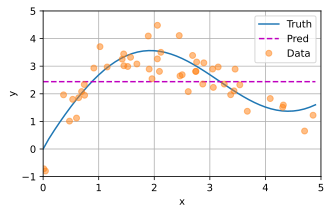

In [15]:
# torch.repeat_interleave(..., n_test)
# 含义：将第 1 步算出来的那个“平均值”，重复 n_test 次。
# 目的：为了画图或计算误差，预测值 y_hat 的形状必须和 x_test 的形状一致（都是长度为 50 的向量）。
# 结果：生成一个长度为 50 的向量，里面的每一个元素全都是那个平均值。
y_hat = torch.repeat_interleave(y_train.mean(), n_test)   
plot_kernel_reg(y_hat)

### 10.2.3 非参数注意力汇聚

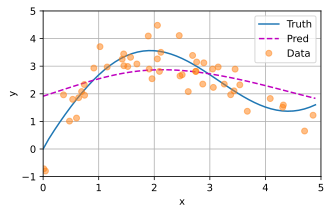

In [16]:
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1,n_train))
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights=nn.functional.softmax(-(X_repeat-x_train)**2/2,dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights,y_train)
plot_kernel_reg(y_hat)

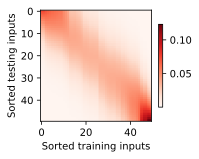

In [17]:
show_heatmaps(
    attention_weights.unsqueeze(0).unsqueeze(0),  #将形状从(50,50)变为(1,50,50)再变为(1,1,50,50),从而才能调用函数
    xlabel='Sorted training inputs', ylabel='Sorted testing inputs')

# torch.unsqueeze(dim)（或者 tensor.unsqueeze(dim)）是 PyTorch 中非常常用的函数。
# 它的核心作用只有一个：升维。
# 具体来说，就是在你指定的 dim（位置）插入一个长度为 1 的新维度。
# 假设你有一个向量 x = [1, 2, 3]，形状是 (3)。
# unsqueeze(0)：在第 0 层加括号。
# 变成：[[1, 2, 3]]
# 形状：(1, 3) —— 变成了一个 1行3列 的矩阵。
# unsqueeze(1)：在第 1 层（每个元素外）加括号。
# 变成：[[1], [2], [3]]
# 形状：(3, 1) —— 变成了一个 3行1列 的矩阵。

# 这里测试数据的输入相当于查询，而训练数据的输入相当于键。因为两个输入都
# 是经过排序的，因此由观察可知“查询‐键”对越接近，注意力汇聚的注意力权重就越高。


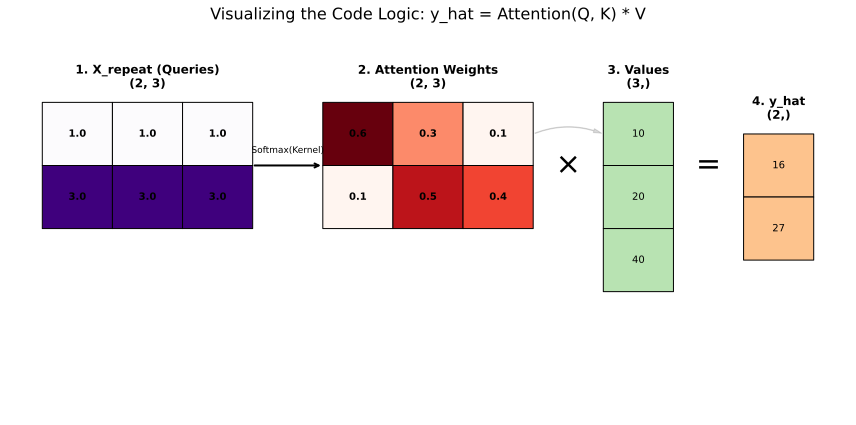

In [18]:
#一个具体的例子来展示流程

# 2 个测试点 (Queries)：x_test = [1.0, 3.0] （想预测 x=1 和 x=3 时的值）
# 3 个训练点 (Keys)：x_train = [1.0, 2.0, 4.0]
# 3 个训练值 (Values)：y_train = [10.0, 20.0, 40.0]


import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
import torch.nn.functional as F

def draw_matrix_flow():
    # 1. 准备真实的演示数据 (2个Query, 3个Key)
    x_test = torch.tensor([1.0, 3.0])       # Query
    x_train = torch.tensor([1.0, 2.0, 4.0]) # Key
    y_train = torch.tensor([10.0, 20.0, 40.0]) # Value
    
    # 2. 真实计算过程
    n_train = len(x_train)
    X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
    # 为了演示方便，我们不取负平方，直接模拟一个简单的Softmax结果
    # 真实计算: attention_weights = F.softmax(-(X_repeat - x_train)**2/2, dim=1)
    # 这里手动写死一个好看的近似值，方便阅读
    att_weights = np.array([
        [0.6, 0.3, 0.1],  # Query 1 (1.0) 离 Key 1 (1.0) 最近
        [0.1, 0.5, 0.4]   # Query 2 (3.0) 在 Key 2 (2.0) 和 Key 3 (4.0) 中间
    ])
    y_hat = att_weights @ y_train.numpy()

    # 3. 开始绘图
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xlim(0, 12)
    ax.set_ylim(0, 6)
    ax.axis('off') # 关掉坐标轴

    # --- 辅助函数：画矩阵 ---
    def draw_mat(x, y, data, title, color='Blues'):
        rows, cols = data.shape
        # 画热力图格子
        for i in range(rows):
            for j in range(cols):
                val = data[i, j]
                # 归一化颜色
                c_val = (val - data.min()) / (data.max() - data.min() + 1e-5)
                rect = patches.Rectangle((x + j, y - i - 1), 1, 1, linewidth=1, edgecolor='black', facecolor=plt.cm.get_cmap(color)(c_val))
                ax.add_patch(rect)
                # 写数值
                ax.text(x + j + 0.5, y - i - 0.5, f"{val:.1f}", ha='center', va='center', fontsize=10, fontweight='bold')
        # 写标题和维度
        ax.text(x + cols/2, y + 0.2, f"{title}\n{data.shape}", ha='center', va='bottom', fontsize=12, fontweight='bold')
        return (x + cols, y - rows/2) # 返回右侧连接点

    # --- 辅助函数：画向量 ---
    def draw_vec(x, y, data, title, color='Greens'):
        rows = len(data)
        for i in range(rows):
            val = data[i]
            rect = patches.Rectangle((x, y - i - 1), 1, 1, linewidth=1, edgecolor='black', facecolor=plt.cm.get_cmap(color)(0.3))
            ax.add_patch(rect)
            ax.text(x + 0.5, y - i - 0.5, f"{val:.0f}", ha='center', va='center', fontsize=10)
        ax.text(x + 0.5, y + 0.2, f"{title}\n({rows},)", ha='center', va='bottom', fontsize=12, fontweight='bold')
        return (x, y - rows/2) # 返回左侧连接点

    # --- 绘制流程 ---

    # 1. 左边：X_repeat (Query矩阵)
    # 模拟 X_repeat 数据
    x_rep_data = np.array([[1, 1, 1], [3, 3, 3]])
    p1_right = draw_mat(0.5, 5, x_rep_data, "1. X_repeat (Queries)", color='Purples')

    # 箭头 1
    ax.annotate("", xy=(4.5, 4), xytext=(3.5, 4), arrowprops=dict(arrowstyle="->", lw=2))
    ax.text(4, 4.2, "Softmax(Kernel)", ha='center', fontsize=9)

    # 2. 中间：Attention Weights
    p2_right = draw_mat(4.5, 5, att_weights, "2. Attention Weights", color='Reds')

    # 乘号
    ax.text(8.0, 4, "×", ha='center', va='center', fontsize=30)

    # 3. 中间偏右：y_train (Values)
    # 调整位置以便对齐
    draw_vec(8.5, 5, y_train.numpy(), "3. Values", color='Greens')

    # 等号
    ax.text(10.0, 4, "=", ha='center', va='center', fontsize=30)

    # 4. 右边：y_hat (Output)
    draw_vec(10.5, 4.5, y_hat, "4. y_hat", color='Oranges')

    # --- 添加解释性连线 (可视化矩阵乘法) ---
    # 从权重的第一行连到 Value
    style = "Simple, tail_width=0.5, head_width=4, head_length=8"
    kw = dict(arrowstyle=style, color="gray", alpha=0.3)
    # 示意：行 * 列
    a1 = patches.FancyArrowPatch((7.5, 4.5), (8.5, 4.5), connectionstyle="arc3,rad=-0.2", **kw)
    ax.add_patch(a1)
    
    plt.title("Visualizing the Code Logic: y_hat = Attention(Q, K) * V", fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

draw_matrix_flow()

### 10.2.4 带参数的注意力汇聚

In [19]:
#批量矩阵乘法

X=torch.ones((2,1,4))
Y=torch.ones((2,4,6))
torch.bmm(X,Y).shape

torch.Size([2, 1, 6])

In [20]:
#使用小批量矩阵乘法来计算小批量数据中的加权平均值

weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
print(weights),print(values)
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))   #(2,1,10)x(2,10,1)=(2,1,1)

tensor([[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
        [10., 11., 12., 13., 14., 15., 16., 17., 18., 19.]])


tensor([[[ 4.5000]],

        [[14.5000]]])

In [21]:
#定义模型
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))
    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))   #构造出一个矩阵，每一行都是同一个 Query，为了方便后面和 keys 矩阵做减法。
        self.attention_weights = nn.functional.softmax(
            -((queries- keys) * self.w)**2 / 2, dim=1)    #dim=1：沿着“列”的方向（即对所有 Keys）做归一化，保证每一行的权重和为 1。
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)



In [22]:
#训练

# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1- torch.eye(n_train)).type(torch.bool)].reshape((n_train,-1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1- torch.eye(n_train)).type(torch.bool)].reshape((n_train,-1))

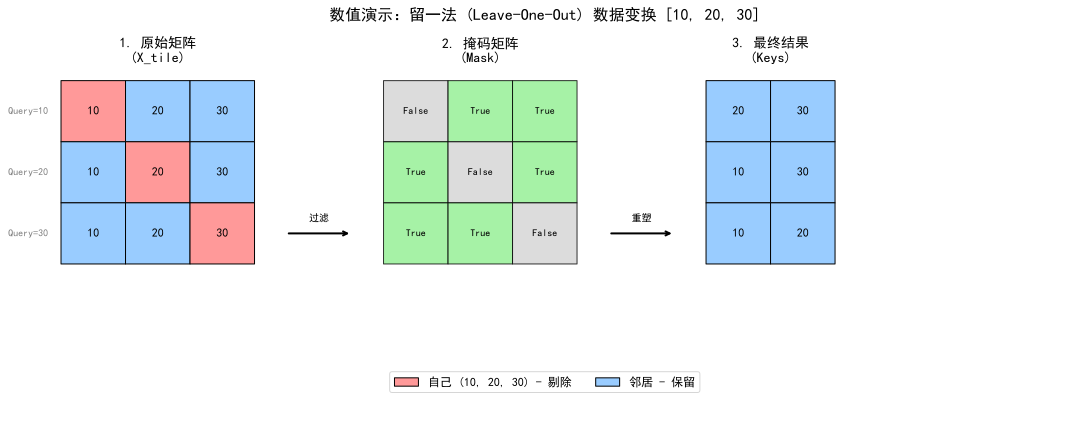

In [23]:
# x_train=[10,20,30]
# X_tile = x_train.repeat((n_train, 1))
# keys = X_tile[(1- torch.eye(n_train)).type(torch.bool)].reshape((n_train,-1))
# 的一个展示例子

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_numerical_example():
    # --- 设置中文字体 ---
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'Microsoft YaHei', 'DejaVu Sans']
    plt.rcParams['axes.unicode_minus'] = False
    
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.set_xlim(0, 16)
    ax.set_ylim(0, 6)
    ax.axis('off')

    # 定义颜色
    C_SELF = '#FF9999'   # 红色 (自己/剔除)
    C_KEEP = '#99CCFF'   # 蓝色 (保留)
    C_MASK_T = '#90EE90' # 绿色 (True)
    C_MASK_F = '#D3D3D3' # 灰色 (False)

    y_pos = 4.5
    
    # ==========================================
    # 1. 原始矩阵 X_tile (数值)
    # ==========================================
    x1 = 0.5
    ax.text(x1 + 1.5, y_pos + 1.3, "1. 原始矩阵\n(X_tile)", ha='center', fontsize=14, fontweight='bold')
    
    data = [[10, 20, 30], 
            [10, 20, 30], 
            [10, 20, 30]]
    
    for i in range(3):
        for j in range(3):
            is_diag = (i == j)
            color = C_SELF if is_diag else C_KEEP
            rect = patches.Rectangle((x1 + j, y_pos - i), 1, 1, ec='black', fc=color)
            ax.add_patch(rect)
            
            # 写数字
            weight = 'bold' if is_diag else 'normal'
            ax.text(x1 + j + 0.5, y_pos - i + 0.5, str(data[i][j]), 
                    ha='center', va='center', fontsize=12, fontweight=weight)
            
            if j == 0:
                ax.text(x1 - 0.2, y_pos - i + 0.5, f"Query={data[i][i]}", ha='right', va='center', color='gray')

    # 箭头
    ax.annotate("", xy=(5.0, 3.0), xytext=(4.0, 3.0), arrowprops=dict(arrowstyle="->", lw=2))
    ax.text(4.5, 3.2, "过滤", ha='center')

    # ==========================================
    # 2. 掩码矩阵 (Mask)
    # ==========================================
    x2 = 5.5
    ax.text(x2 + 1.5, y_pos + 1.3, "2. 掩码矩阵\n(Mask)", ha='center', fontsize=14, fontweight='bold')
    
    for i in range(3):
        for j in range(3):
            is_diag = (i == j)
            color = C_MASK_F if is_diag else C_MASK_T
            rect = patches.Rectangle((x2 + j, y_pos - i), 1, 1, ec='black', fc=color, alpha=0.8)
            ax.add_patch(rect)
            
            txt = "False" if is_diag else "True"
            ax.text(x2 + j + 0.5, y_pos - i + 0.5, txt, ha='center', va='center', fontsize=10)

    # 箭头
    ax.annotate("", xy=(10.0, 3.0), xytext=(9.0, 3.0), arrowprops=dict(arrowstyle="->", lw=2))
    ax.text(9.5, 3.2, "重塑", ha='center')

    # ==========================================
    # 3. 最终结果 (Result)
    # ==========================================
    x3 = 10.5
    ax.text(x3 + 1.0, y_pos + 1.3, "3. 最终结果\n(Keys)", ha='center', fontsize=14, fontweight='bold')
    
    # 手动填入结果数据
    final_data = [[20, 30], 
                  [10, 30], 
                  [10, 20]]
    
    for i in range(3):
        for j in range(2):
            rect = patches.Rectangle((x3 + j, y_pos - i), 1, 1, ec='black', fc=C_KEEP)
            ax.add_patch(rect)
            ax.text(x3 + j + 0.5, y_pos - i + 0.5, str(final_data[i][j]), 
                    ha='center', va='center', fontsize=12)

    # ==========================================
    # 图例
    # ==========================================
    legend_elements = [
        patches.Patch(facecolor=C_SELF, edgecolor='black', label='自己 (10, 20, 30) - 剔除'),
        patches.Patch(facecolor=C_KEEP, edgecolor='black', label='邻居 - 保留'),
    ]
    ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 0.05), ncol=2, fontsize=12)

    plt.title("数值演示：留一法 (Leave-One-Out) 数据变换 [10, 20, 30]", fontsize=16, pad=30)
    plt.tight_layout()
    plt.show()

visualize_numerical_example()

In [24]:
class Animator: 
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                ylim=None, xscale='linear', yscale='linear',
                fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):   
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

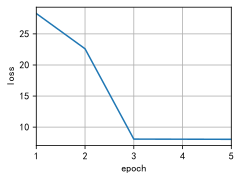

In [25]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')   #reduction='none'：这是一个关键细节。默认情况下，PyTorch 的 Loss 会直接返回一个标量（所有样本误差的平均值）。设置 none 后，它会返回一个向量，形状为 (n_train,)，保留了每一个样本的单独误差。这样做通常是为了后续更灵活的处理（比如手动求和）。
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train) / 2
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

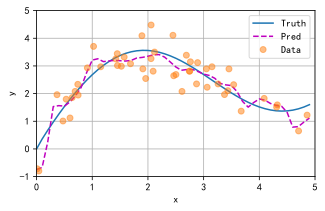

In [26]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

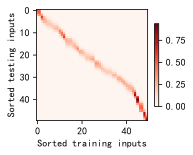

In [27]:
show_heatmaps(
    net.attention_weights.unsqueeze(0).unsqueeze(0),
    xlabel='Sorted training inputs', ylabel='Sorted testing inputs')


### 10.3 注意力评分函数

In [28]:
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value  #~mask将mask中的布尔值转换，并将True的变为value
    return X

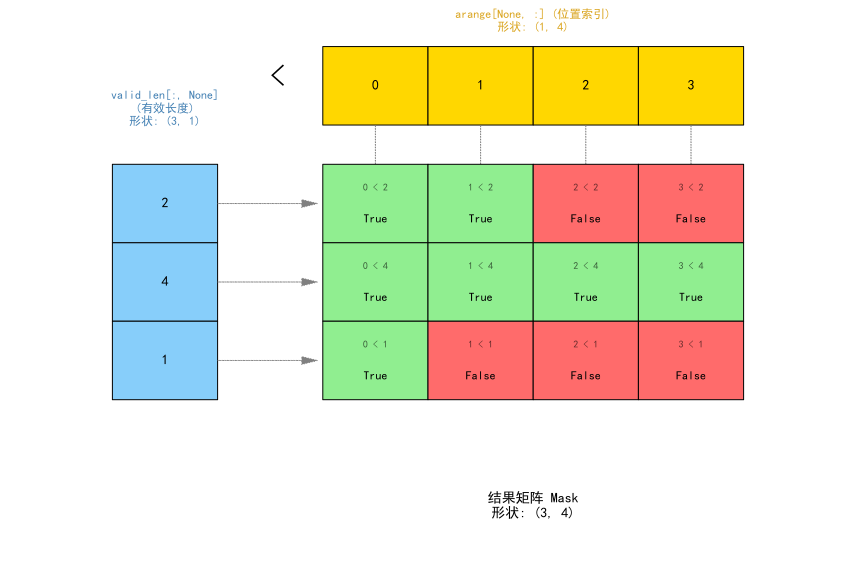

In [29]:
#valid_len为[2,4,1]的演示图演示图
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def visualize_broadcasting_logic():
    # 设置中文字体
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'Microsoft YaHei', 'DejaVu Sans']
    plt.rcParams['axes.unicode_minus'] = False
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_xlim(0, 8)
    ax.set_ylim(0, 7)
    ax.axis('off')

    # 数据
    maxlen = 4
    indices = np.arange(maxlen)       # [0, 1, 2, 3]
    valid_lens = np.array([2, 4, 1])  # [2, 4, 1]

    # 颜色
    C_IDX = '#FFD700'   # 金色 (索引)
    C_LEN = '#87CEFA'   # 蓝色 (长度)
    C_TRUE = '#90EE90'  # 绿色 (True)
    C_FALSE = '#FF6B6B' # 红色 (False)

    # ==========================================
    # 1. 绘制上方的横向向量 (arange[None, :])
    # ==========================================
    x_start = 3
    y_top = 5.5
    
    ax.text(x_start + 2, y_top + 1.2, "arange[None, :] (位置索引)\n形状: (1, 4)", 
            ha='center', fontsize=12, fontweight='bold', color='#DAA520')

    for j in range(maxlen):
        rect = patches.Rectangle((x_start + j, y_top), 1, 1, ec='black', fc=C_IDX)
        ax.add_patch(rect)
        ax.text(x_start + j + 0.5, y_top + 0.5, str(indices[j]), 
                ha='center', va='center', fontsize=14, fontweight='bold')
        # 画向下的虚线箭头，表示广播
        ax.arrow(x_start + j + 0.5, y_top, 0, -0.8, head_width=0.1, color='gray', linestyle=':')

    # ==========================================
    # 2. 绘制左侧的纵向向量 (valid_len[:, None])
    # ==========================================
    x_left = 1
    y_grid_start = 4
    
    ax.text(x_left + 0.5, y_grid_start + 1.5, "valid_len[:, None]\n(有效长度)\n形状: (3, 1)", 
            ha='center', fontsize=12, fontweight='bold', color='#4682B4')

    for i in range(3):
        rect = patches.Rectangle((x_left, y_grid_start - i), 1, 1, ec='black', fc=C_LEN)
        ax.add_patch(rect)
        ax.text(x_left + 0.5, y_grid_start - i + 0.5, str(valid_lens[i]), 
                ha='center', va='center', fontsize=14, fontweight='bold')
        # 画向右的虚线箭头，表示广播
        ax.arrow(x_left + 1, y_grid_start - i + 0.5, 0.8, 0, head_width=0.1, color='gray', linestyle=':')

    # ==========================================
    # 3. 绘制中间的广播结果矩阵 (The Broadcast Result)
    # ==========================================
    ax.text(x_start + 2, y_grid_start - 3.5, "结果矩阵 Mask\n形状: (3, 4)", 
            ha='center', fontsize=14, fontweight='bold')
    
    # 运算符号
    ax.text(2.5, 6, "<", fontsize=30, fontweight='bold')

    for i in range(3):
        for j in range(maxlen):
            # 核心逻辑
            idx_val = indices[j]
            len_val = valid_lens[i]
            result = idx_val < len_val
            
            color = C_TRUE if result else C_FALSE
            
            # 画格子
            rect = patches.Rectangle((x_start + j, y_grid_start - i), 1, 1, ec='black', fc=color)
            ax.add_patch(rect)
            
            # 显示比较公式
            formula = f"{idx_val} < {len_val}"
            res_text = "True" if result else "False"
            
            ax.text(x_start + j + 0.5, y_grid_start - i + 0.7, formula, 
                    ha='center', va='center', fontsize=10, color='black', alpha=0.6)
            ax.text(x_start + j + 0.5, y_grid_start - i + 0.3, res_text, 
                    ha='center', va='center', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

visualize_broadcasting_logic()

In [30]:
#遮蔽softmax操作
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上遮蔽元素来执行 softmax 操作"""
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [31]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.4588, 0.5412, 0.0000, 0.0000],
         [0.5161, 0.4839, 0.0000, 0.0000]],

        [[0.4456, 0.3323, 0.2221, 0.0000],
         [0.2672, 0.2611, 0.4717, 0.0000]]])

In [32]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2806, 0.4084, 0.3109, 0.0000]],

        [[0.4884, 0.5116, 0.0000, 0.0000],
         [0.2365, 0.3981, 0.1797, 0.1858]]])

### 10.3.2 加性注意力

In [33]:
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)


    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在维度扩展后，
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        # key的形状：(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使用广播方式进行求和
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [34]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])

print(queries),print(keys),print(values)


tensor([[[ 1.1264,  1.0046,  0.0075,  1.6512, -0.2454, -0.1733, -0.4413,
          -1.5957, -0.1101,  0.0406, -1.3045,  0.3213,  0.6036,  1.0091,
          -0.4605,  1.0777, -0.4666, -0.2648, -1.2359, -1.2915]],

        [[ 0.3136, -1.2593, -0.2584,  0.6953, -0.5520, -0.8473,  0.9944,
           0.3223, -0.9467,  0.8315, -0.8776, -0.1284,  1.0351,  0.4263,
           0.8310, -1.3482,  0.8361, -0.1984,  1.2626, -1.3550]]])
tensor([[[1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.]],

        [[1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.]]])
tensor([[[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.],
         [12., 13., 14., 15.],
         [16., 17., 18., 19.],
         [20., 21., 22., 23.],
    

(None, None, None)

In [35]:
attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.eval()  #切换到评估模式，禁用丢弃
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

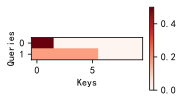

In [36]:
show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')                   #将两个Batch拼在了一起而不是两个子图

### 10.3.3 缩放点积注意力

In [37]:
import math
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [38]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

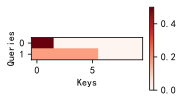

In [39]:

show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')                   #将两个Batch拼在了一起而不是两个子图

## 10.4 Bahdanau注意力

In [40]:
class Decoder(nn.Module):
    """编码器-解码器架构的基本解码器接口"""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        
    def init_state(self, enc_outputs, *args):
        raise NotImplementedError
    
    def forward(self, X, state):
        raise NotImplementedError

In [41]:
class EncoderDecoder(nn.Module):
    """编码器-解码器架构的基类"""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

In [42]:
class AttentionDecoder(Decoder):
    """带有注意力机制的解码器基本接口"""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property
    def attention_weights(self):
        raise NotImplementedError

### 10.4.2 定义注意力解码器

In [43]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
    dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = AdditiveAttention(
            num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # outputs的形状为(batch_size，num_steps，num_hiddens).
        # hidden_state的形状为(num_layers，batch_size，num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # enc_outputs的形状为(batch_size,num_steps,num_hiddens).
        # hidden_state的形状为(num_layers,batch_size, num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # 输出X的形状为(num_steps,batch_size,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # query的形状为(batch_size,1,num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # context的形状为(batch_size,1,num_hiddens)
            context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
            # 在特征维度上连结
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # 将x变形为(1,batch_size,embed_size+num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # 全连接层变换后，outputs的形状为
        # (num_steps,batch_size,vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
        enc_valid_lens]


    @property
    def attention_weights(self):
        return self._attention_weights

In [44]:
class Encoder(nn.Module):
    """编码器-解码器架构的基本编码器接口"""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError

In [45]:
class Seq2SeqEncoder(Encoder):
    """用于序列到序列学习的循环神经网络编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
        dropout=dropout)

    def forward(self, X, *args):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X)
        # 在循环神经网络模型中，第一个轴对应于时间步
        X = X.permute(1, 0, 2)
        # 如果未提及状态，则默认为0
        output, state = self.rnn(X)
        # output的形状:(num_steps,batch_size,num_hiddens)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

In [46]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                             num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                                  num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

### 10.4.3 训练

## 10.5多头注意力

### 10.5.2 实现

In [47]:
def transpose_qkv(X, num_heads):
    """为了多注意力头的并行计算而变换形状"""
    # 输入X的形状:(batch_size，查询或者“键－值”对的个数，num_hiddens)
    # 输出X的形状:(batch_size，查询或者“键－值”对的个数，num_heads，num_hiddens/num_heads)
    X = X.reshape(X.shape[0], X.shape[1], num_heads,-1)   #将hidden分成两个维度
    # 输出X的形状:(batch_size，num_heads，查询或者“键－值”对的个数, num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3)  #交换顺序
    # 最终输出的形状:(batch_size*num_heads,查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])   #把前两个维度合成一个维度

def transpose_output(X, num_heads):    #把上面那个的操作反过来做了一遍
    """逆转transpose_qkv函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1],-1)

In [48]:
import math 


class MultiHeadAttention(nn.Module):
    """多头注意力"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
    num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # queries，keys，values的形状:
        # (batch_size，查询或者“键－值”对的个数，num_hiddens)
        # valid_lens　的形状:
        # (batch_size，)或(batch_size，查询的个数)
        # 经过变换后，输出的queries，keys，values　的形状:
        # (batch_size*num_heads，查询或者“键－值”对的个数，
        # num_hiddens/num_heads)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            # 在轴0，将第一项（标量或者矢量）复制num_heads次，
            # 然后如此复制第二项，然后诸如此类。
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)   # # repeat_interleave 会把 [1, 2] 变成 [1, 1, ..., 2, 2, ...]
            
        # output的形状:(batch_size*num_heads，查询的个数，
        # num_hiddens/num_heads)
        
        output = self.attention(queries, keys, values, valid_lens)
        # output_concat的形状:(batch_size，查询的个数，num_hiddens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

In [49]:
#键值相同的例子
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                            num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [50]:
batch_size, num_queries = 2, 4
num_kvpairs, valid_lens = 6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])

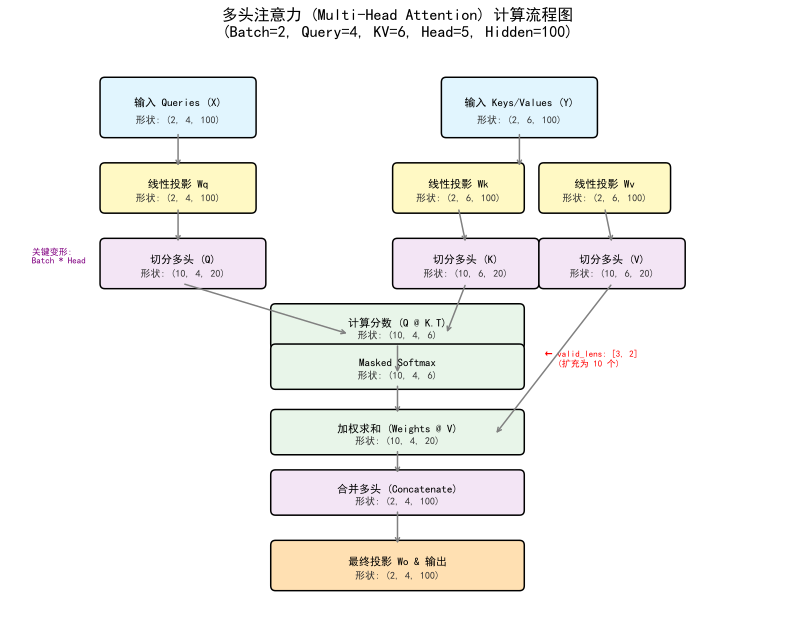

In [51]:
#上面例子的一个可视流程图

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_multihead_attention_flow_fixed():
    # 设置中文字体 (根据系统环境可能需要调整)
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'Microsoft YaHei', 'DejaVu Sans']
    plt.rcParams['axes.unicode_minus'] = False

    fig, ax = plt.subplots(figsize=(14, 10))
    ax.set_xlim(0, 16)
    ax.set_ylim(0, 11)
    ax.axis('off')

    # 定义颜色
    C_IN = '#E1F5FE'    # 输入 (浅蓝)
    C_OP = '#FFF9C4'    # 操作 (浅黄)
    C_TRANS = '#F3E5F5' # 变形 (浅紫)
    C_CORE = '#E8F5E9'  # 核心计算 (浅绿)
    C_OUT = '#FFE0B2'   # 输出 (浅橙)

    # --- 辅助函数：画带形状的框 ---
    def draw_node(x, y, w, h, title, shape, color):
        rect = patches.FancyBboxPatch((x, y), w, h, boxstyle="round,pad=0.1", ec="black", fc=color, lw=1.5)
        ax.add_patch(rect)
        ax.text(x + w/2, y + h*0.6, title, ha='center', va='center', fontsize=11, fontweight='bold')
        ax.text(x + w/2, y + h*0.25, f"形状: {shape}", ha='center', va='center', fontsize=10, color='#333333')

    # --- 1. 输入层 ---
    draw_node(2, 9.5, 3, 1, "输入 Queries (X)", "(2, 4, 100)", C_IN)
    draw_node(9, 9.5, 3, 1, "输入 Keys/Values (Y)", "(2, 6, 100)", C_IN)

    # --- 2. 线性投影层 ---
    y_lin = 8.0
    draw_node(2, y_lin, 3, 0.8, "线性投影 Wq", "(2, 4, 100)", C_OP)
    draw_node(8, y_lin, 2.5, 0.8, "线性投影 Wk", "(2, 6, 100)", C_OP)
    draw_node(11, y_lin, 2.5, 0.8, "线性投影 Wv", "(2, 6, 100)", C_OP)

    # --- 3. 切分多头 (transpose_qkv) ---
    y_trans = 6.5
    draw_node(2, y_trans, 3.2, 0.8, "切分多头 (Q)", "(10, 4, 20)", C_TRANS)
    draw_node(8, y_trans, 2.8, 0.8, "切分多头 (K)", "(10, 6, 20)", C_TRANS)
    draw_node(11, y_trans, 2.8, 0.8, "切分多头 (V)", "(10, 6, 20)", C_TRANS)
    
    ax.text(0.5, y_trans+0.4, "关键变形:\nBatch * Head", color='purple', fontsize=9, fontweight='bold')

    # --- 4. 注意力核心计算 ---
    y_core = 4.5
    draw_node(5.5, y_core+0.8, 5, 0.7, "计算分数 (Q @ K.T)", "(10, 4, 6)", C_CORE)
    draw_node(5.5, y_core, 5, 0.7, "Masked Softmax", "(10, 4, 6)", C_CORE)
    ax.text(11, y_core+0.35, "← valid_lens: [3, 2]\n   (扩充为 10 个)", color='red', fontsize=9)
    
    draw_node(5.5, 3.2, 5, 0.7, "加权求和 (Weights @ V)", "(10, 4, 20)", C_CORE)

    # --- 5. 合并多头 (transpose_output) ---
    draw_node(5.5, 2.0, 5, 0.7, "合并多头 (Concatenate)", "(2, 4, 100)", C_TRANS)

    # --- 6. 最终输出 ---
    draw_node(5.5, 0.5, 5, 0.8, "最终投影 Wo & 输出", "(2, 4, 100)", C_OUT)

    # --- 修正后的箭头绘制 ---
    # 定义箭头属性字典
    ap = dict(arrowstyle="->", color="gray", lw=1.5)

    # 绘制连接线
    # 输入到线性
    ax.annotate("", xy=(3.5, 8.8), xytext=(3.5, 9.5), arrowprops=ap)
    ax.annotate("", xy=(10.5, 8.8), xytext=(10.5, 9.5), arrowprops=ap)
    # 线性到切分
    ax.annotate("", xy=(3.5, 7.3), xytext=(3.5, 8.0), arrowprops=ap)
    ax.annotate("", xy=(9.4, 7.3), xytext=(9.25, 8.0), arrowprops=ap)
    ax.annotate("", xy=(12.4, 7.3), xytext=(12.25, 8.0), arrowprops=ap)
    # 切分到核心计算
    ax.annotate("", xy=(7.0, 5.5), xytext=(3.6, 6.5), arrowprops=ap) # Q
    ax.annotate("", xy=(9.0, 5.5), xytext=(9.4, 6.5), arrowprops=ap) # K
    # 核心计算内部
    ax.annotate("", xy=(8.0, 4.7), xytext=(8.0, 5.3), arrowprops=ap)
    ax.annotate("", xy=(8.0, 3.9), xytext=(8.0, 4.5), arrowprops=ap)
    # V 连到加权求和
    ax.annotate("", xy=(10.0, 3.5), xytext=(12.4, 6.5), arrowprops=ap)
    # 合并到最终
    ax.annotate("", xy=(8.0, 2.7), xytext=(8.0, 3.2), arrowprops=ap)
    ax.annotate("", xy=(8.0, 1.3), xytext=(8.0, 2.0), arrowprops=ap)

    plt.title("多头注意力 (Multi-Head Attention) 计算流程图\n(Batch=2, Query=4, KV=6, Head=5, Hidden=100)", fontsize=16, pad=20)
    plt.show()

draw_multihead_attention_flow_fixed()

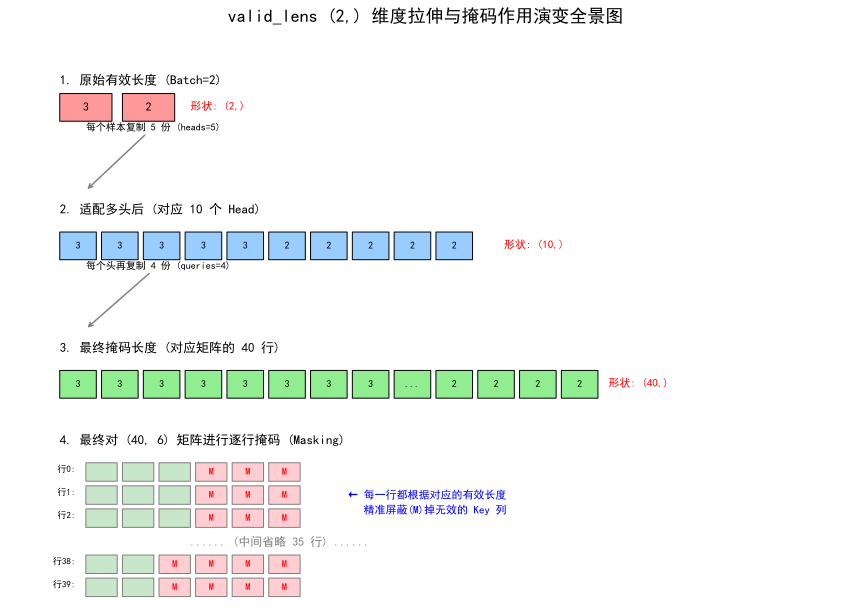

In [52]:
#掩码过程的可视化

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_valid_len_expansion_v2():
    # 设置中文字体
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'Microsoft YaHei', 'DejaVu Sans']
    plt.rcParams['axes.unicode_minus'] = False

    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_xlim(0, 16)
    ax.set_ylim(0, 12)
    ax.axis('off')

    # 颜色定义
    C_V1 = '#FF9999' # 原始
    C_V2 = '#99CCFF' # 适配多头
    C_V3 = '#90EE90' # 最终掩码
    C_MAT_V = '#C8E6C9' # 有效格子
    C_MAT_M = '#FFCDD2' # 屏蔽格子

    # --- 1. 原始 valid_lens (2,) ---
    y1 = 10.5
    ax.text(1, y1 + 0.8, "1. 原始有效长度 (Batch=2)", fontsize=13, fontweight='bold')
    v1 = [3, 2]
    for i, val in enumerate(v1):
        rect = patches.Rectangle((1 + i*1.2, y1), 1, 0.6, ec='black', fc=C_V1)
        ax.add_patch(rect)
        ax.text(1 + i*1.2 + 0.5, y1 + 0.3, str(val), ha='center', va='center', fontweight='bold', fontsize=12)
    ax.text(3.5, y1 + 0.25, "形状: (2,)", color='red', fontweight='bold', fontsize=11)

    # 箭头 1
    ax.annotate("每个样本复制 5 份 (heads=5)", xy=(1.5, 9.0), xytext=(1.5, 10.3),
                arrowprops=dict(arrowstyle="->", color='gray', lw=1.5), fontsize=10)

    # --- 2. 适配多头后的 valid_lens (10,) ---
    y2 = 7.5
    ax.text(1, y2 + 1.0, "2. 适配多头后 (对应 10 个 Head)", fontsize=13, fontweight='bold')
    v2 = [3,3,3,3,3, 2,2,2,2,2]
    for i, val in enumerate(v2):
        rect = patches.Rectangle((1 + i*0.8, y2), 0.7, 0.6, ec='black', fc=C_V2)
        ax.add_patch(rect)
        ax.text(1 + i*0.8 + 0.35, y2 + 0.3, str(val), ha='center', va='center', fontsize=10)
    ax.text(9.5, y2 + 0.25, "形状: (10,)", color='red', fontweight='bold', fontsize=11)

    # 箭头 2
    ax.annotate("每个头再复制 4 份 (queries=4)", xy=(1.5, 6.0), xytext=(1.5, 7.3),
                arrowprops=dict(arrowstyle="->", color='gray', lw=1.5), fontsize=10)

    # --- 3. 适配查询后的 valid_lens (40,) ---
    y3 = 4.5
    ax.text(1, y3 + 1.0, "3. 最终掩码长度 (对应矩阵的 40 行)", fontsize=13, fontweight='bold')
    v3_show = [3,3,3,3, 3,3,3,3, "...", 2,2,2,2]
    for i, val in enumerate(v3_show):
        rect = patches.Rectangle((1 + i*0.8, y3), 0.7, 0.6, ec='black', fc=C_V3)
        ax.add_patch(rect)
        ax.text(1 + i*0.8 + 0.35, y3 + 0.3, str(val), ha='center', va='center', fontsize=10)
    ax.text(11.5, y3 + 0.25, "形状: (40,)", color='red', fontweight='bold', fontsize=11)

    # --- 4. 作用于展平后的矩阵 (40, 6) ---
    x_mat = 1.5
    y_mat = 0.5
    ax.text(1, y_mat + 3.0, "4. 最终对 (40, 6) 矩阵进行逐行掩码 (Masking)", fontsize=13, fontweight='bold')
    
    # 绘制前 3 行 (样本1, 长度3)
    for i in range(3):
        ax.text(x_mat - 0.2, y_mat + 2.2 - i*0.5 + 0.2, f"行{i}:", ha='right', fontsize=9)
        for j in range(6):
            is_valid = j < 3
            color = C_MAT_V if is_valid else C_MAT_M
            rect = patches.Rectangle((x_mat + j*0.7, y_mat + 2.2 - i*0.5), 0.6, 0.4, ec='gray', fc=color)
            ax.add_patch(rect)
            if not is_valid:
                ax.text(x_mat + j*0.7 + 0.3, y_mat + 2.2 - i*0.5 + 0.2, "M", ha='center', va='center', color='red', fontsize=10, fontweight='bold')

    ax.text(x_mat + 2.0, y_mat + 0.8, "...... (中间省略 35 行) ......", fontsize=12, color='gray')

    # 绘制最后 2 行 (样本2, 长度2)
    for i in range(2):
        idx = 38 + i
        ax.text(x_mat - 0.2, y_mat + 0.2 - i*0.5 + 0.2, f"行{idx}:", ha='right', fontsize=9)
        for j in range(6):
            is_valid = j < 2
            color = C_MAT_V if is_valid else C_MAT_M
            rect = patches.Rectangle((x_mat + j*0.7, y_mat + 0.2 - i*0.5), 0.6, 0.4, ec='gray', fc=color)
            ax.add_patch(rect)
            if not is_valid:
                ax.text(x_mat + j*0.7 + 0.3, y_mat + 0.2 - i*0.5 + 0.2, "M", ha='center', va='center', color='red', fontsize=10, fontweight='bold')

    ax.text(6.5, y_mat + 1.5, "← 每一行都根据对应的有效长度\n   精准屏蔽(M)掉无效的 Key 列", color='blue', fontsize=11, linespacing=1.5)

    plt.title("valid_lens (2,) 维度拉伸与掩码作用演变全景图", fontsize=18, pad=30)
    plt.show()

visualize_leave_one_out_v2 = visualize_valid_len_expansion_v2()


## 10.6 自注意力和位置编码

### 10.6.1 自注意力

In [53]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                                   num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [54]:
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
attention(X, X, X, valid_lens).shape   #Q,K,V都是X，即是自注意机制

torch.Size([2, 4, 100])

### 10.6.3 位置编码

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(
                10000,
                torch.arange(0, num_hiddens, 2, dtype=torch.float32) /
                num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)  #矩阵的每个位置加上一个编码
        return self.dropout(X)

In [71]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline
def use_svg_display():
    # 设置Matplotlib使用SVG格式显示
    backend_inline.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)): 
    """设置matplotlib的图表大小"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()


def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """绘制数据点"""
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    # 如果X有一个轴，输出True
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

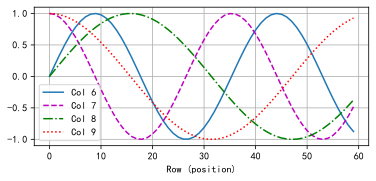

In [72]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)]);

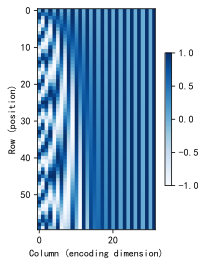

In [73]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
show_heatmaps(P, xlabel='Column (encoding dimension)',
                  ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')

## 10.7 Transformer!!!